In [1]:
import numpy as np
import emcee
from matplotlib import pyplot as plt
from operator import itemgetter
from scipy.stats import uniform, norm
from functools import reduce
from os.path import join, abspath
from os import pardir, mkdir
import sys
import vaex

In [2]:
# import utils
util_dir = abspath(pardir)
sys.path.insert(0, util_dir)

In [3]:
from utils import nu_mod_total

In [4]:
root_data_dir = abspath(join(pardir, "Data"))
root_data_dir

'/home2/s20321005/Thesis-Project/Data'

In [8]:
data_baryon_dir = join(root_data_dir, "Baryon")
data_number_dir = join(root_data_dir, "Number-Density")
data_velocity_dir = join(root_data_dir, "Spectral-Class-Velocity")
data_uncertainty_dir = join(root_data_dir, "Uncertainty")
data_dir_mcmc = join(root_data_dir, "MCMC")

In [6]:
# load baryons components
df = vaex.open(join(data_baryon_dir, "baryon.hdf5"))
df

#,components,rho,e_rho,sigma_z,e_sigma_z
0,Molecular gas (H2),0.0104,0.00312,3.7,0.2
1,Cold atomic gas (HI(1)),0.0277,0.00554,7.1,0.5
2,Warm atomic gas (HI(2)),0.0073,0.0007,22.1,2.4
3,Hot ionized gas (HII),0.0005,3e-05,39.0,4.0
4,Giant stars,0.0006,6e-05,15.5,1.6
...,...,...,...,...,...
7,4 < MV < 5,0.0029,0.00029,18.0,1.8
8,5 < MV < 8,0.0072,0.00072,18.5,1.9
9,MV > 8,0.0216,0.0028,18.5,4.0
10,White dwarfs,0.0056,0.001,20.0,5.0


In [7]:
def log_prior(theta, pars):
  args = ('rhos', 'sigmaz', 'rhoDM', 'sigmaDD', 'hDD', 'Nv', 'zsun')
  rhos, sigmaz, rhoDM, sigmaDD, hDD, Nv, zsun = itemgetter(*args)(theta)
  args = ('rhos_mean', 'rhos_std', 'sigmaz_mean', 'sigmaz_std', 'rhoDM_loc', 
          'rhoDM_scale', 'sigmaDD_loc', 'sigmaDD_scale', 'hDD_loc', 'hDD_scale', 
          'Nv_loc', 'Nv_scale', 'zsun_loc', 'zsun_scale')
  rhos_mean, rhos_std, sigmaz_mean, sigmaz_std, rhoDM_loc, rhoDM_scale, sigmaDD_loc, sigmaDD_scale, hDD_loc, hDD_scale, Nv_loc, Nv_scale, zsun_loc, zsun_scale = itemgetter(*args)(pars)
  uni_loc = np.array([rhoDM_loc, sigmaDD_loc, hDD_loc, Nv_loc, zsun_loc])
  uni_scale = np.array([rhoDM_scale, sigmaDD_scale, hDD_scale, Nv_scale, zsun_scale])
  uni_val = rhoDM, sigmaDD, hDD, Nv, zsun
  log_uni = np.sum(uniform.logpdf(uni_val, loc=uni_loc, scale=uni_scale))
  result = np.sum(norm.logpdf(rhos, loc=rhos_mean, scale=rhos_std))+np.sum(norm.logpdf(sigmaz, loc=sigmaz_mean, scale=sigmaz_std))+log_uni
  return result

In [9]:
# Test Prior

rhos = df["rho"].to_numpy()  # Msun/pc^3
rhos_std = df["e_rho"].to_numpy()
sigmaz = df["sigma_z"].to_numpy() # km/s
sigmaz_std = df["e_sigma_z"].to_numpy()

# test the following dark values
rhoDM = -0.016 # Msun/pc^3
sigmaDD = 7 # Msun/pc^2
zsun = 0 # pc
hDD = 65 # pc
NvA = 1
NvF = 1
NvG = 1

# theta = dict(rhos=rhos, sigmaz=sigmaz, rhoDM=rhoDM, sigmaDD=sigmaDD, hDD=hDD, NvA=NvA, NvF=NvF, NvG=NvG ,zsun=zsun)
theta = dict(rhos=rhos, sigmaz=sigmaz, rhoDM=rhoDM, sigmaDD=sigmaDD, hDD=hDD, Nv=NvA ,zsun=zsun)
pars = dict(rhos_mean=rhos, rhos_std=rhos_std, sigmaz_mean=sigmaz, sigmaz_std=sigmaz_std, 
            rhoDM_loc=0, rhoDM_scale=0.06, sigmaDD_loc=0, sigmaDD_scale=30, hDD_loc=0, hDD_scale=100, 
            Nv_loc=12, Nv_scale=1, zsun_loc=-0.05, zsun_scale=0.1)
# uni_loc = np.array([0, 0, 0, 0.9, 0.9, 0.9, -0.03]) # [rhoDM, sigmaDD, hDD, NvA, NvF, NvG, zsun]
# uni_scale = np.array([0.06, 30,  100, 2, 2, 2, 0.03])
# uni_loc = np.array([0, 0, 0, 0.9, -0.03]) # [rhoDM, sigmaDD, hDD, NvA, NvF, NvG, zsun]
# uni_scale = np.array([0.06, 30,  100, 2, 0.03])

log_prior(theta, pars)

-inf

In [10]:
def log_likelihood(theta, nu_data, tipe='A'):
  args = ('rhos', 'sigmaz', 'rhoDM', 'sigmaDD', 'hDD', 'Nv', 'zsun')
  rhos, sigmaz, rhoDM, sigmaDD, hDD, Nv, zsun = itemgetter(*args)(theta)
  zz, Nv_data, e_Nv = itemgetter('z','logNv', 'e_Nv')(nu_data)
  logNv_model, logNv_model_std = nu_mod_total(zz, theta, tipe=tipe)
  tot_err = np.sqrt(logNv_model_std**2 + e_Nv**2)
  result = np.sum(norm.logpdf(Nv+logNv_model, loc=Nv_data, scale=tot_err))
  return result

In [11]:
df_v = vaex.open(join(data_number_dir, "density.hdf5"))
df_v

#,z,z_lower,z_upper,A,e_A,F,e_F,G,e_G
0,-0.1904761904761905,-0.2,-0.18095238095238098,26156.689302838415,5033.857203367721,581325.731109716,23673.4138532323,758139.0064176286,26837.829906684645
1,-0.17142857142857143,-0.18095238095238098,-0.1619047619047619,36001.93304937468,5918.681334352472,623270.9772575898,24598.543351867265,796105.2990230077,27566.87197733039
2,-0.1523809523809524,-0.1619047619047619,-0.14285714285714285,41102.47613849389,6342.249759906555,775003.9163147459,27521.196011266195,867296.9678728126,28845.868066584422
3,-0.13333333333333333,-0.14285714285714285,-0.12380952380952381,59355.62897282102,7662.778750513408,833868.8029450909,28635.172257938983,903057.0580259662,29501.588149832558
4,-0.1142857142857143,-0.12380952380952381,-0.10476190476190476,95211.53110580808,9768.496978344137,1030291.3867801373,31902.000311075786,1007300.7792433458,31235.071201237817
...,...,...,...,...,...,...,...,...,...
16,0.1142857142857143,0.10476190476190478,0.12380952380952381,120660.59745015114,11300.900358878187,938406.4080751899,31159.27335666387,1008826.6502250796,32192.95204084632
17,0.13333333333333333,0.12380952380952381,0.14285714285714285,85885.84443067272,9484.504868706048,863149.0082777579,29781.470159649467,919588.7694917227,30687.074696435484
18,0.1523809523809524,0.14285714285714285,0.16190476190476194,74715.83773812081,8805.34592110983,846354.0114990416,29395.089830250425,838241.1869962689,29272.652008002322
19,0.17142857142857146,0.16190476190476194,0.18095238095238098,42251.719640679745,6598.610002547659,746992.1756824645,27553.22148728981,859926.2531721198,29635.015738685124


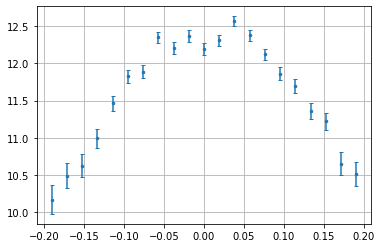

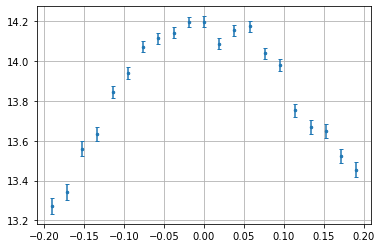

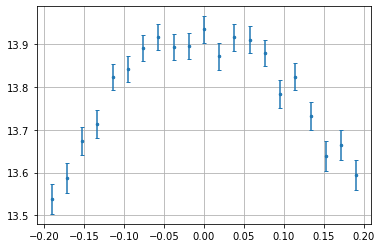

In [12]:
zz = df_v["z"].to_numpy()
for num, num_err in [(df_v["A"].to_numpy(), df_v["e_A"].to_numpy()), (df_v["F"].to_numpy(), df_v["e_F"].to_numpy()), (df_v["G"].to_numpy(), df_v["e_G"].to_numpy())]:
  plt.figure()
  plt.errorbar(zz, np.log(num), yerr=num_err/num, fmt=".", markersize=5, capsize=2)
  plt.grid()
  plt.show()

In [53]:
# def safe_div(x, y):
#   c = np.divide(x, y, out=np.zeros_like(x), where=(y!=0))
#   return c

# def nu_mod_total(zz, theta, tipe="A", res=1000):
#   data_dir = join(root_data_dir, "Velocity-Distribution")
#   df_velocity = vaex.open(join(data_dir, "Velocity-Distribution.hdf5"))
#   index = 0 if tipe=="A" else 1 if tipe=="F" else 2
#   sigma_v = df_velocity["sigma"].to_numpy()[index]
#   logNu_sys, logNu_sys_std = asymmerty_uncertainties(zz, theta, tipe=tipe)
#   logNu_stat, logNu_stat_std = nu_bootstrap(zz, theta, tipe=tipe, res=res)
#   above = logNu_stat*logNu_stat_std**2+logNu_sys*logNu_sys_std**2
#   below = logNu_stat_std**2+logNu_sys_std**2
#   logNu_mean = safe_div(above, below)
#   logNu_std = np.sqrt(logNu_stat_std**2+logNu_sys_std**2)
#   return logNu_mean, logNu_std

In [13]:
# Test likelihood

theta = dict(rhos=rhos, sigmaz=sigmaz, rhoDM=rhoDM, sigmaDD=sigmaDD, hDD=hDD, Nv=12 ,zsun=zsun)
nu_data = dict(z=df_v.z.to_numpy(), logNv=np.log(df_v["A"].to_numpy()), e_Nv=df_v["e_A"].to_numpy()/df_v["A"].to_numpy())
log_likelihood(theta, nu_data, tipe='A') 

-93.23245200981445

In [14]:
def log_posterior(x, priors, tipe='A'):
  theta = dict(rhos=x[0:12], sigmaz=x[12:24], rhoDM=x[24], sigmaDD=x[25], hDD=x[26], Nv=x[27], zsun=x[28])
  locs, scales = itemgetter('locs', 'scales')(priors)
  pars = dict(rhos_mean=locs[0:12], rhos_std=scales[0:12], sigmaz_mean=locs[12:24], sigmaz_std=scales[12:24], 
              rhoDM_loc=locs[24], rhoDM_scale=scales[24], sigmaDD_loc=locs[25], sigmaDD_scale=scales[25], 
              hDD_loc=locs[26], hDD_scale=scales[26], Nv_loc=locs[27], Nv_scale=scales[27], zsun_loc=locs[28], 
              zsun_scale=scales[28])
  log_prior_ = log_prior(theta, pars)
  if not np.isfinite(log_prior_):
      return -np.inf
  data_number_dir = join(root_data_dir, "Number-Density")
  df = vaex.open(join(data_number_dir, "density.hdf5"))
  nu_data = dict(z=df.z.to_numpy(), logNv=np.log(df[tipe].to_numpy()), e_Nv=df["e_"+tipe].to_numpy()/df[tipe].to_numpy())
  log_likelihood_ = log_likelihood(theta, nu_data, tipe=tipe)
  # return log_prior(theta, pars) + log_likelihood(theta, nu_data, tipe=tipe)
  return log_prior_ + log_likelihood_

In [15]:
# test log posterior
locs = [*rhos, *sigmaz, 0, 0, 0, 12, 0]
scales = [*rhos_std, *sigmaz_std, 0.06, 30, 100, 13, 0.05]
priors = dict(locs=locs, scales=scales)
# locs = [*rhos, *sigmaz, rhoDM_loc, sigmaDD_loc, hDD_loc, Nv_loc, zsun_loc]
# scales = [*rhos_std, *sigmaz_std, rhoDM_scale, sigmaDD_scale, hDD_scale, Nv_scale, zsun_scale]
# priors = dict(locs=locs, scales=scales)
rhoDM = 0.016 # Msun/pc^3
sigmaDD = 7 # Msun/pc^2
zsun = 0 # pc
hDD = 65 # pc
NvA = 1
x = np.array([*rhos, *sigmaz, rhoDM, sigmaDD, hDD, 12, 0])
log_posterior(x, priors, tipe='A')

-38.47910256308055

In [16]:
name = "MCMC"
data_dir_mcmc = join(root_data_dir, name)
try:
  mkdir(data_dir_mcmc)
  print(f"Creating {name} dir in Data dir")
except FileExistsError:
  print("Directory already exist. Good to go!")

Directory already exist. Good to go!


In [17]:
# example mcmc
# np.random.seed(42)
ndim = 29
nwalkers = ndim*2
rhos_0 = np.random.normal(loc=rhos, scale=rhos_std, size=(nwalkers, 12))
sigmaz_0 = np.random.normal(loc=sigmaz, scale=sigmaz_std, size=(nwalkers, 12))
rhoDM_loc, rhoDM_scale = 0, 0.06
rhoDM_0 = np.random.uniform(low=rhoDM_loc, high=rhoDM_loc+rhoDM_scale, size=nwalkers)
sigmaDD_loc, sigmaDD_scale = 0, 30
sigmaDD_0 = np.random.uniform(low=sigmaDD_loc, high=sigmaDD_loc+sigmaDD_scale, size=nwalkers)
hDD_loc, hDD_scale = 0, 100
hDD_0 = np.random.uniform(low=hDD_loc, high=hDD_loc+hDD_scale, size=nwalkers)
Nv_loc, Nv_scale = 12, 1
Nv_0 = np.random.uniform(low=Nv_loc, high=Nv_loc+Nv_scale, size=nwalkers)
zsun_loc, zsun_scale = -0.05, 0.10
zsun_0 = np.random.uniform(low=zsun_loc, high=zsun_loc+zsun_scale, size=nwalkers)

p0 = np.array([*rhos_0.T, *sigmaz_0.T, rhoDM_0, sigmaDD_0, hDD_0, Nv_0, zsun_0]).T

In [18]:
filename = join(data_dir_mcmc, "chain-A.hdf5")
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

In [19]:
# A
locs = [*rhos, *sigmaz, rhoDM_loc, sigmaDD_loc, hDD_loc, Nv_loc, zsun_loc]
scales = [*rhos_std, *sigmaz_std, rhoDM_scale, sigmaDD_scale, hDD_scale, Nv_scale, zsun_scale]
priors = dict(locs=locs, scales=scales)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[priors, "A"], backend=backend)

In [20]:
state = sampler.run_mcmc(p0, 100, progress=True)
state

 18%|█▊        | 18/100 [00:31<02:19,  1.70s/it]/home2/s20321005/Thesis-Project/utils.py:136: RuntimeWarning: overflow encountered in cosh
  return 1/np.cosh(x)
100%|██████████| 100/100 [02:58<00:00,  1.79s/it]


State([[ 7.93235288e-03  2.30286989e-02  7.79566560e-03 ...  4.53064981e+01
   1.24954252e+01  1.46456881e-02]
 [ 9.16974903e-03  2.87177571e-02  7.95174548e-03 ...  4.22034195e+01
   1.24913771e+01 -1.02347328e-02]
 [ 1.01382408e-02  3.36047511e-02  6.79689563e-03 ...  6.75679071e+01
   1.24651587e+01 -1.45755220e-02]
 ...
 [ 8.32461647e-03  3.23631025e-02  6.10324514e-03 ...  7.44976240e+01
   1.23941563e+01  6.92036849e-03]
 [ 9.45151681e-03  2.97335097e-02  6.85100947e-03 ...  1.94355977e+00
   1.25137506e+01  3.47393933e-03]
 [ 9.82787218e-03  1.49001740e-02  7.54102736e-03 ...  1.01311494e+01
   1.26228646e+01  2.86902913e-02]], log_prob=[23.81226661 24.03618929 36.55433816 26.02884961 27.8426907  30.66385967
 22.26802617 15.77156378 25.27063303 27.18272622 20.85001028 18.34657175
 15.26424278 26.87704469 25.83486357 30.04893759 24.61318434 21.59941178
 13.79430664 13.02505309 20.45356851 38.20695393 23.64153136 22.46598808
 14.76320526 20.94345316 28.35283286 26.37879235 23.5319

Text(0.5, 0, 'step number')

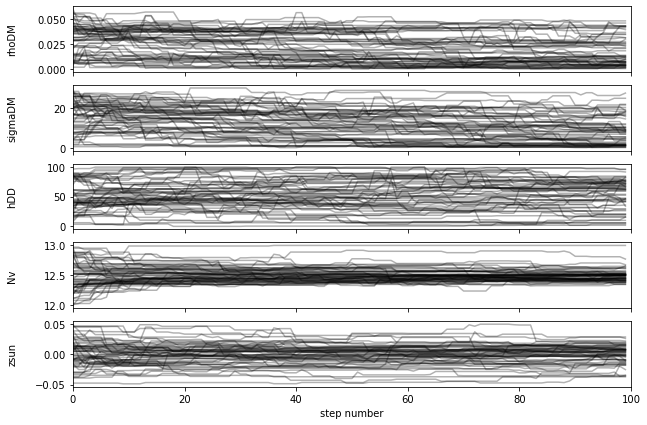

In [21]:
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["rhoDM", "sigmaDM", "hDD", "Nv", "zsun"]
for i in range(5):
    ax = axes[i]
    ax.plot(samples[:, :, i+24], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [22]:
reader = emcee.backends.HDFBackend(filename)

# samples = reader.get_chain(discard=burnin, flat=True, thin=thin)
reader

In [24]:
reader.get_last_sample()

State([[ 7.93235288e-03  2.30286989e-02  7.79566560e-03 ...  4.53064981e+01
   1.24954252e+01  1.46456881e-02]
 [ 9.16974903e-03  2.87177571e-02  7.95174548e-03 ...  4.22034195e+01
   1.24913771e+01 -1.02347328e-02]
 [ 1.01382408e-02  3.36047511e-02  6.79689563e-03 ...  6.75679071e+01
   1.24651587e+01 -1.45755220e-02]
 ...
 [ 8.32461647e-03  3.23631025e-02  6.10324514e-03 ...  7.44976240e+01
   1.23941563e+01  6.92036849e-03]
 [ 9.45151681e-03  2.97335097e-02  6.85100947e-03 ...  1.94355977e+00
   1.25137506e+01  3.47393933e-03]
 [ 9.82787218e-03  1.49001740e-02  7.54102736e-03 ...  1.01311494e+01
   1.26228646e+01  2.86902913e-02]], log_prob=[23.81226661 24.03618929 36.55433816 26.02884961 27.8426907  30.66385967
 22.26802617 15.77156378 25.27063303 27.18272622 20.85001028 18.34657175
 15.26424278 26.87704469 25.83486357 30.04893759 24.61318434 21.59941178
 13.79430664 13.02505309 20.45356851 38.20695393 23.64153136 22.46598808
 14.76320526 20.94345316 28.35283286 26.37879235 23.5319

In [28]:
run2_backend = emcee.backends.HDFBackend(filename, name="mcmc_second_prior")
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[priors, "A"], backend=run2_backend)

In [29]:
sampler.reset()
sampler.run_mcmc(reader.get_last_sample(), 100, progress=True)

100%|██████████| 100/100 [05:39<00:00,  3.40s/it]


State([[ 8.22519820e-03  2.77978366e-02  7.75537306e-03 ...  4.43235568e+01
   1.24408028e+01  9.87465725e-03]
 [ 8.38727234e-03  2.68891331e-02  7.66074435e-03 ...  5.15423108e+01
   1.24961149e+01 -1.53787471e-02]
 [ 1.06595220e-02  3.56010580e-02  6.63637382e-03 ...  7.32571230e+01
   1.24706621e+01 -1.91634134e-02]
 ...
 [ 7.95069015e-03  3.22059338e-02  6.13534371e-03 ...  8.24681373e+01
   1.24673376e+01  4.04441642e-03]
 [ 7.61558736e-03  3.10044321e-02  7.48072858e-03 ...  6.44499488e+00
   1.24767060e+01 -5.51354790e-03]
 [ 1.24291322e-02  2.28271674e-02  7.38254961e-03 ...  2.52825801e+01
   1.26035716e+01  2.78653808e-02]], log_prob=[18.70504318 25.89444495 35.64979484 31.61277264 32.42991142 33.04175302
 34.70589082 30.24419905 28.13837077 34.60544172 27.85329784 32.73394998
 30.15518508 16.09169862 31.36563682 26.21023893 31.5575599  22.29972715
 17.66436299 20.39666889 28.07902833 31.2410698  34.55059526 38.59557875
 35.62683291 34.1307293  28.93981834 28.37333019 31.6375

Text(0.5, 0, 'step number')

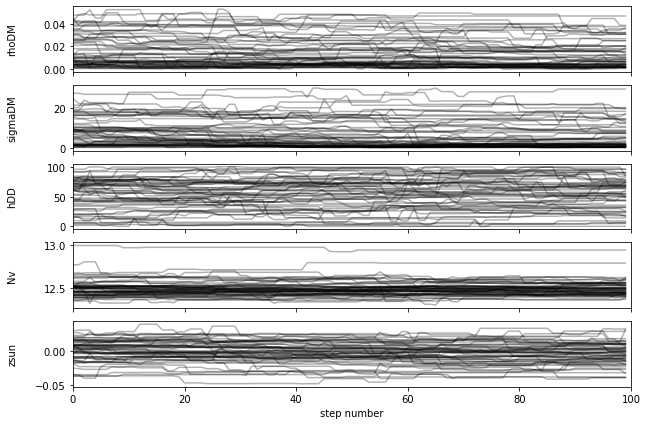

In [30]:
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["rhoDM", "sigmaDM", "hDD", "Nv", "zsun"]
for i in range(5):
    ax = axes[i]
    ax.plot(samples[:, :, i+24], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [ ]:
print(
    "Mean acceptance fraction: {0:.3f}".format(
        np.mean(sampler.acceptance_fraction)
    )
)
print(
    "Mean autocorrelation time: {0:.3f} steps".format(
        np.mean(sampler.get_autocorr_time())
    )
)

In [22]:
filename = join(data_dir_mcmc, "chain-A.h5")

reader = emcee.backends.HDFBackend(filename, name="mcmc_second_prior")

# samples = reader.get_chain(discard=burnin, flat=True, thin=thin)
# reader

Text(0.5, 0, 'step number')

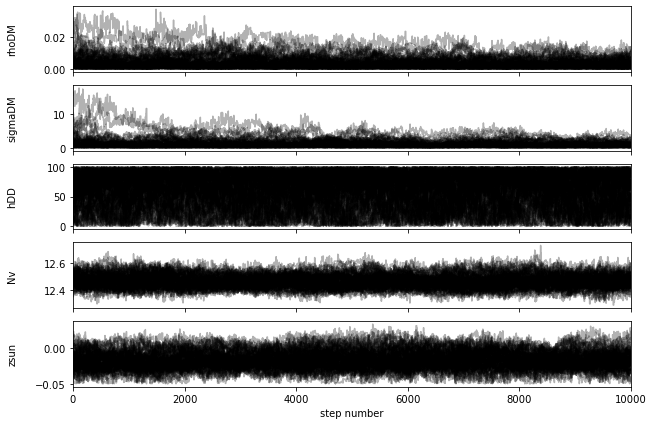

In [23]:
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = reader.get_chain()
labels = ["rhoDM", "sigmaDM", "hDD", "Nv", "zsun"]
for i in range(5):
    ax = axes[i]
    ax.plot(samples[:, :, i+24], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [25]:
import corner

log_prob_samples = reader.get_log_prob()
log_prior_samples = reader.get_blobs()
flat_samples = reader.get_chain(discard=0, flat=True)
flat_samples

array([[ 2.53962755e-03,  1.87345371e-02,  7.93591180e-03, ...,
         8.29479458e+01,  1.25249462e+01, -2.44232842e-02],
       [ 4.40231219e-03,  2.09284015e-02,  6.86118820e-03, ...,
         9.99763069e+01,  1.25651285e+01, -2.93800676e-02],
       [ 9.53749254e-03,  1.66904089e-02,  7.57236306e-03, ...,
         5.11413725e+01,  1.25510606e+01, -3.62844307e-02],
       ...,
       [ 9.94525578e-03,  1.69455390e-02,  6.20409059e-03, ...,
         5.41528484e+01,  1.24470987e+01, -2.50870846e-02],
       [ 5.80650406e-03,  2.95472589e-02,  6.86207096e-03, ...,
         8.64412303e+01,  1.24720397e+01, -6.45686860e-03],
       [ 8.74974956e-03,  1.45762796e-02,  6.94753199e-03, ...,
         6.41492759e+01,  1.24553031e+01, -2.33767085e-02]])

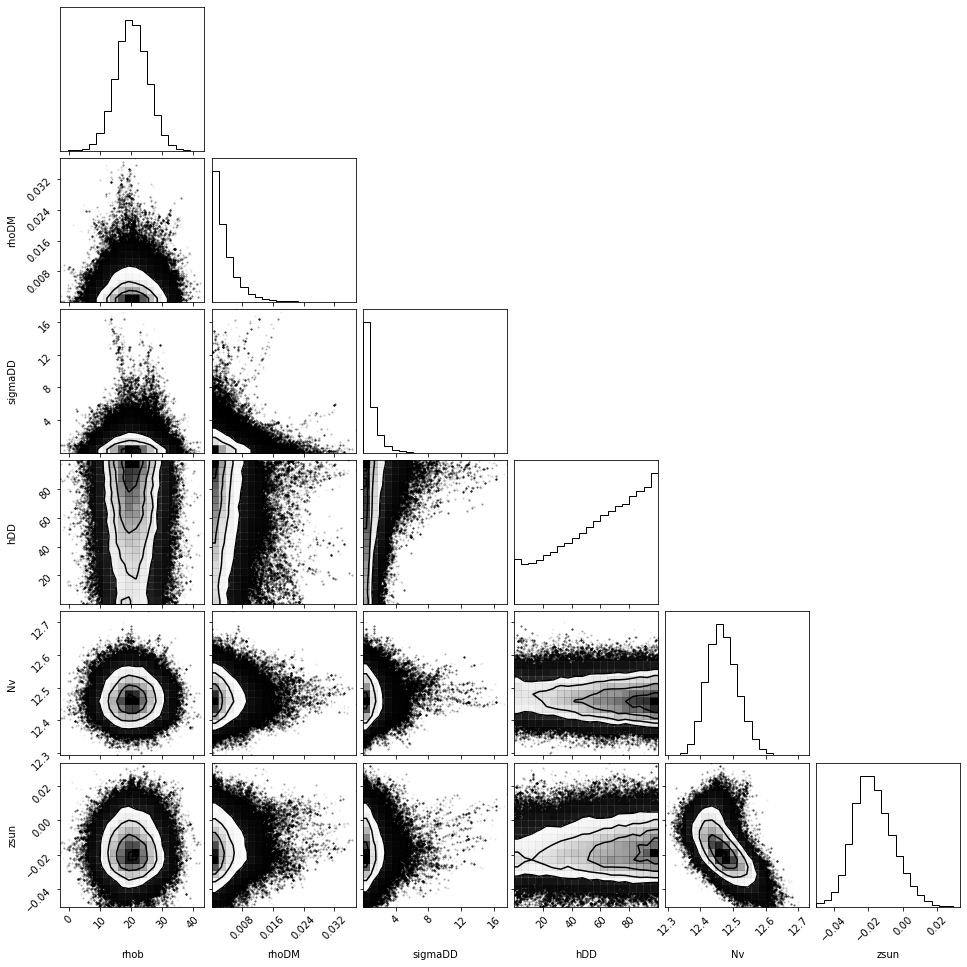

In [32]:
fig = corner.corner(
    flat_samples[:,23:], labels=["rhob", "rhoDM", "sigmaDD", "hDD", "Nv", "zsun"]
);

In [31]:
flat_samples[:,0].shape

(1000000,)

In [ ]:
# samples = sampler.get_chain()
# df_dict = dict(step=samples[:, :, 0][0] ,rho0=samples[:, :, 0][1], rho1=samples[:, :, 1][1], rho2=samples[:, :, 1][1], 
#           rho3=samples[:, "", 3][1], rho4=samples[:, :, 4][1], rho5=samples[:, :, 5][1], rho6=samples[:, :, 6][1],
#           rho7=samples[:, :, 7][1], rho8=samples[:, :, 8][1], rho9=samples[:, :, 9][1], rho10=samples[:, :, 10][1],
#           rho11=samples[:, :, 11][1], sigmaz0=samples[:, :, 12][1], sigmaz1=samples[:, :, 13][1], sigmaz2=samples[:, :, 14][1],
#           sigmaz3=samples[:, :, 15][1], sigmaz4=samples[:, :, 16][1], sigmaz5=samples[:, :, 17][1], sigmaz6=samples[:, :, 18][1],
#           sigmaz7=samples[:, :, 19][1], sigmaz8=samples[:, :, 20][1], sigmaz9=samples[:, :, 21][1], sigmaz10=samples[:, :, 22][1],
#           sigmaz11=samples[:, :, 23][1], rhoDM=samples[:, :, 24][1], sigmaDD=samples[:, :, 25][1], hDD=samples[:, :, 26][1],
#           Nv=samples[:, :, 27][1], zsun=samples[:, :, 28][1])
# df = vaex.from_dict(df_dict)      
# df.export_hdf5(join(data_dir_mcmc, "A.hdf5"))    